# Huspriser

In [ ]:
# importer pakker

# Add pip install?

import numpy as np
import pandas as pd
pd.set_option('display.expand_frame_repr', False)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import lightgbm as lgb
from lightgbm import LGBMRegressor, early_stopping
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor


In [ ]:
# importer data fra csv-fil (excel)
data = pd.read_csv('HousingPrices_selected.csv', sep=',')

# print første 5 rækker data
print(data.head(5))

   Postnummer  Husnummer  kvadratmeter  Grundareal  Byggeår  afstand_skole  afstand_supermarked  Salgspris
0      4953.0        9.0            97       949.0   1942.0        5425.42              5551.78    1050000
1      2300.0       12.0            86         0.0   2006.0        1045.23               132.97    1352500
2      2300.0       12.0            86         0.0   2006.0        1045.23               132.97    3500000
3      2300.0       16.0            95         0.0   2007.0        1017.53               153.93    3463432
4      2300.0       18.0            73         0.0   2007.0        1004.49               166.23    2700000


In [17]:
# Vi vil gerne forudse salgspris. Derfor laver vi et datasæt, input_data, uden priserne, så algoritmen ikke kan "snyde"
# Vi laver også et datasæt med sandheden, truth_data, altså de rigtige salgspriser
variabler       = data.columns
input_variabler = variabler[(variabler != 'Salgspris')]
input_data      = data[input_variabler]
truth_data      = data['Salgspris']

In [18]:
# vi bruger train_test_split til at splitte data i et træningssæt og et testsæt.
# træningssættet bruges til at træne modellen, hvor modellen får salgspriserne at vide.
# testsættet bruges til at give den trænede model data uden salgspriser, som den så skal forudsige.

data_træning, data_test, sande_pris_træning, sande_pris_test = \
    train_test_split(input_data, truth_data, test_size=0.25, random_state=42)

## (Boosted) Decision trees

In [19]:
# Vi giver træningsdata og testsdata til LightGBM:
lgb_train = lgb.Dataset(data_træning, sande_pris_træning)
lgb_test  = lgb.Dataset(data_test,  sande_pris_test, reference=lgb_train)
    
# Her sætter vi "Hyper parametre" for modellen.
hyper_parameters = {
    'objective': 'regression', # regression bruges når vi gerne vil forudsige en kontinuert værdi
    'metric': 'mae',           # hvilken 'fejl' den skal bruge til at optimere efter. 
    'num_leaves': 10,          # antal blade pr. træ
    'num_boost_round': 10      # Hvor mange "runder" den må køre for at optimere
}

# Træn modellen:
gbm_test = lgb.train(
        hyper_parameters,                   # Hyper parametre som vi definerede ovenfor
        lgb_train,                          # Data til at træne modellen
        valid_sets=lgb_test,                # Data til at teste modellen
        callbacks=[early_stopping(15)]      # Stop med at optimere hvis der ikke ses forbedringer efter N antal runder.
)     
                                                    

# Lav forudsigelser med den trænede model
forudsagte_pris = gbm_test.predict(data_test, num_iteration=gbm_test.best_iteration)  

# vi bruger r^2 til at vurdere resultatet. Jo tættere på 1, jo bedre er den til at forudsige.
r2 = r2_score(sande_pris_test, forudsagte_pris)
print(f"R²: {r2:.3f}")
print(f"MAE: {mean_absolute_error(sande_pris_test, forudsagte_pris):,.0f}")
    


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1683
[LightGBM] [Info] Number of data points in the train set: 35781, number of used features: 7
[LightGBM] [Info] Start training from score 1867082.744613
Training until validation scores don't improve for 15 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's l1: 744341
R²: 0.410
MAE: 744,341


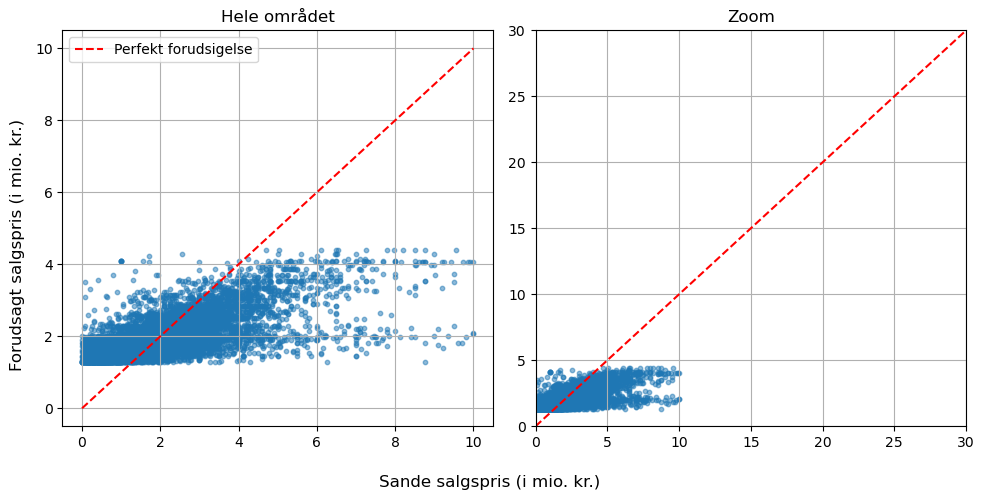

In [20]:
# Vi plotter de forudsagte værdier mod de sande værdier. 

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
mio = 1e6 # vi dividerer med 10^6 for at få tallene i hele milioner.

###---- VENSTRE PLOT -----###
ax = axes[0]
ax.scatter(sande_pris_test/mio, forudsagte_pris/mio, alpha=0.5, s=10)
full_min = min(np.min(sande_pris_test), np.min(forudsagte_pris))/mio
full_max = max(np.max(sande_pris_test), np.max(forudsagte_pris))/mio
ax.plot([full_min, full_max], [full_min, full_max], 'r--', label='Perfekt forudsigelse')
ax.grid(True)
ax.legend()
ax.set_title('Hele området')

###---- HØJRE PLOT -----###
ax = axes[1]
ax.scatter(sande_pris_test/mio, forudsagte_pris/mio, alpha=0.5, s=10)
zoom_min = 0
zoom_max = 30   # Her kan vi bestemme akserne på zoom-ind plottet
ax.plot([zoom_min, zoom_max], [zoom_min, zoom_max], 'r--', label='Perfekt forudsigelse')
ax.set_xlim(zoom_min, zoom_max)
ax.set_ylim(zoom_min, zoom_max)
ax.grid(True)
ax.set_title('Zoom')

fig.supxlabel('Sande salgspris (i mio. kr.)')
fig.supylabel('Forudsagt salgspris (i mio. kr.)')
axes[0].legend()
plt.tight_layout()
plt.show()

# Lav boks med R^2 og mae, evt farv hvor mange punkter er indenfor 10% afvigelse?

For at sige vi har en god model, skal vi helst ligge på den røde linje. 
Prøv at justere på parameterne "num_leaves" og "num_boost_round" for at forbedre forudsigelserne.

- note:
evt kunne man lave sådan at de selv finder en salgsannonce, sætter dataen ind, og ser hvor godt modellen kan gætte. eller tag et af data punkterne, lad dem selv gætte, lad modellen gætte og sammenlign med rigtige resultat?

Forklar og brug gain til at vise hvilke parametre den vurderer som vigtige

# Neurale Netværk (NN)

Neurale netværk er mere følsomme overfor det data vi giver dem. Den fungerer bedst hvis resultatet er værdier mellem 0 og 1. Derfor bruger vi en funktion til at skalere vores data.

In [21]:
scaler = StandardScaler()

data_træning = scaler.fit_transform(data_træning)
data_test = scaler.transform(data_test)

In [22]:
# Her bygger vi det neurale netværk
hyper_parameters_NN = {
    'first_layer': 128,      # Her definerer vi hvor mange lag der skal være, og hvor mange 'neuroner' 
    'second_layer': 64,      # hvert lag skal have. Prøv at ændre på antal neuroner eller at tilføje 
    'third_layer': 32,       # flere lag for at forbedre din model
}

# Her bliver lagene lagt sammen
_order = ['first_layer','second_layer','third_layer','fourth_layer','fifth_layer',
          'sixth_layer','seventh_layer','eighth_layer','ninth_layer','tenth_layer']
hidden_sizes = tuple(hyper_parameters_NN[k] for k in _order if k in hyper_parameters_NN)

# Her er modellen. Der er også andre hyperparametre vi kan justere på. Slå dem evt. op og find ud af hvordan 
# de kan justeres.
mlp = MLPRegressor(
    hidden_layer_sizes=hidden_sizes, 
    max_iter=2000,
    solver='adam',
    activation='relu',
    n_iter_no_change=20,
    early_stopping = True,
    validation_fraction = 0.1,
    learning_rate_init= 1e-3,
    random_state=42
)

mlp.fit(data_træning, sande_pris_træning)  # Træn på datasættet

forudsagte_pris = mlp.predict(data_test)  # Få forudsigelser ved at køre testdataen på modellen
print(f"R²:  {r2_score(sande_pris_test, forudsagte_pris):.3f}")               
print(f"MAE: {mean_absolute_error(sande_pris_test, forudsagte_pris):,.0f}")   

R²:  -1.879
MAE: 635,704


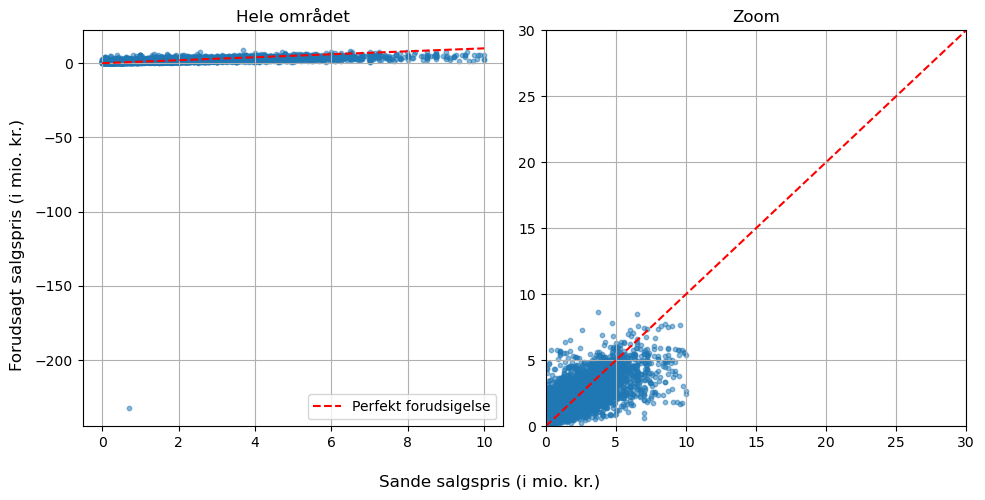

In [23]:
# Vi plotter de forudsagte værdier mod de sande værdier. 

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

###---- VENSTRE PLOT -----###
ax = axes[0]
ax.scatter(sande_pris_test/mio, forudsagte_pris/mio, alpha=0.5, s=10)
ax.plot([full_min, full_max], [full_min, full_max], 'r--', label='Perfekt forudsigelse')
ax.grid(True)
ax.legend()
ax.set_title('Hele området')

###---- HØJRE PLOT -----###
ax = axes[1]
ax.scatter(sande_pris_test/mio, forudsagte_pris/mio, alpha=0.5, s=10)
ax.plot([zoom_min, zoom_max], [zoom_min, zoom_max], 'r--', label='Perfekt forudsigelse')
ax.set_xlim(zoom_min, zoom_max)
ax.set_ylim(zoom_min, zoom_max)
ax.grid(True)
ax.set_title('Zoom')

fig.supxlabel('Sande salgspris (i mio. kr.)')
fig.supylabel('Forudsagt salgspris (i mio. kr.)')
axes[0].legend()
plt.tight_layout()
plt.show()

### Extra
Det kan være svært at finde frem til hvad de bedste hyper parameter for en model er, især når vi har med neurale netværk at gøre. Derfor kan man lave noget der hedder hyper parameter optimization....

#